<a href="https://colab.research.google.com/github/Fadelmuhammad013/Machine-learning/blob/main/UTS/Regressions_Models/Regression_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np

# Contoh data (ganti dengan dataset nyata Anda)
df = pd.read_csv("sample_data/RegresiUTSTelkom.csv")

# Cek missing value dan isi/drop
df.dropna(inplace=True)  # atau df.fillna(df.mean(), inplace=True)

# Cek duplikat
df.drop_duplicates(inplace=True)


In [6]:
from sklearn.feature_selection import VarianceThreshold, mutual_info_regression, f_regression
import numpy as np
import pandas as pd

# Misalnya dataset df sudah dipisah: X = df.drop("target", axis=1), y = df["target"]
X = df.drop("2001", axis=1)
y = df["2001"]

# --- a. Hapus fitur dengan Variance rendah (constant & quasi-constant) ---
var_thresh = VarianceThreshold(threshold=0.01)
X_var = var_thresh.fit_transform(X)
X = X.iloc[:, var_thresh.get_support()]  # Pilih kolom yang lolos threshold

# --- b. Hapus kolom duplikat dengan cara cepat ---
def drop_duplicate_columns_fast(df: pd.DataFrame) -> pd.DataFrame:
    """
    Hapus kolom duplikat dari DataFrame dengan cepat menggunakan hashing tiap kolom.
    """
    seen = set()
    unique_cols = []

    for col in df.columns:
        # Convert kolom ke tuple agar hashable
        col_hash = hash(tuple(df[col].values))
        if col_hash not in seen:
            seen.add(col_hash)
            unique_cols.append(col)

    return df[unique_cols]

X = drop_duplicate_columns_fast(X)

# --- c. Hapus fitur dengan korelasi sangat tinggi (> 0.95) ---
cor_matrix = X.corr().abs()
upper = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.95)]
X.drop(columns=to_drop_corr, inplace=True)

# --- d. Feature Importance via Mutual Information ---
X_sample = X.sample(n=10000, random_state=42)
y_sample = y.loc[X_sample.index]

mi = mutual_info_regression(X_sample, y_sample, discrete_features=False)
mi_scores = pd.Series(mi, index=X_sample.columns).sort_values(ascending=False)

# --- e. F-test (ANOVA) untuk seleksi linearitas fitur ---
f_scores, _ = f_regression(X, y)
anova_scores = pd.Series(f_scores, index=X.columns).sort_values(ascending=False)

# --- f. Ambil fitur top-N (misal 10) dari kombinasi MI & ANOVA ---
top_features = mi_scores.head(10).index.union(anova_scores.head(10).index)
X = X[top_features]


In [7]:
# Misalnya kita ingin melakukan log transformasi pada fitur 'feature1'
if 'feature1' in X.columns:
    X['feature1_log'] = np.log1p(X['feature1'])  # log(1 + X['feature1'])
# Jika ada fitur kategorikal
if 'categorical_feature' in X.columns:
    X = pd.get_dummies(X, columns=['categorical_feature'], drop_first=True)
from sklearn.preprocessing import LabelEncoder

# Jika ada fitur kategorikal yang perlu di-encode
if 'categorical_feature' in X.columns:
    le = LabelEncoder()
    X['categorical_feature'] = le.fit_transform(X['categorical_feature'])
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# MinMaxScaler
scaler_minmax = MinMaxScaler()
X_minmax_scaled = scaler_minmax.fit_transform(X)
# Misalnya kita ingin membuat fitur baru berdasarkan perkalian dua fitur
if 'feature1' in X.columns and 'feature2' in X.columns:
    X['feature1_feature2'] = X['feature1'] * X['feature2']
# Misalnya kita ingin membuat bin berdasarkan fitur 'feature'
bins = [0, 10, 50, 100]
labels = ['low', 'medium', 'high']
# Membuat fitur interaksi antara dua fitur
if 'feature1' in X.columns and 'feature2' in X.columns:
    X['feature1_feature2_interaction'] = X['feature1'] * X['feature2']
# Ambil top-N fitur berdasarkan Mutual Information dan ANOVA
top_features = mi_scores.head(10).index.union(anova_scores.head(10).index)
X = X[top_features]


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer

# Define preprocessing: using StandardScaler for all features as an example
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), X.columns)  # Apply StandardScaler to all columns
    ]
)

# Split Data
# Gunakan sampling data hanya untuk KNN dan SVR
# Gunakan subset data yang lebih kecil untuk model berat
X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, train_size=0.2, random_state=42)


# Semua model regresi
models = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression": Pipeline([("poly", PolynomialFeatures(degree=2)), ("lr", LinearRegression())]),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "K-Nearest Neighbors Regressor": KNeighborsRegressor(n_neighbors=5, algorithm='ball_tree', n_jobs=-1),
    "Bagging Regressor": BaggingRegressor(),
    "AdaBoost Regressor": AdaBoostRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "SVR": SVR(kernel='linear', max_iter=1000)

}


In [15]:
import math

print("Evaluasi Model:\n")
for name, model in models.items():
    if name in ["K-Nearest Neighbors Regressor", "SVR"]:
        model.fit(X_train_small, y_train_small)
    else:
        model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{name:30} {rmse:<10.6f} {mse:<12.6f} {r2:.6f}")


Evaluasi Model:

Linear Regression              10.041800  100.837755   0.150532
Polynomial Regression          9.645733   93.040170    0.216220
Decision Tree Regressor        13.495008  182.115233   -0.534158
K-Nearest Neighbors Regressor  11.225816  126.018948   -0.061597
Bagging Regressor              9.823031   96.491935    0.187142
AdaBoost Regressor             12.432023  154.555200   -0.301989
Gradient Boosting Regressor    9.525259   90.730551    0.235676


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVR                            28.430105  808.270853   -5.808959


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Evaluasi Model:

Linear Regression              RMSE: 10.041800  MSE: 100.837755   R²: 0.150532


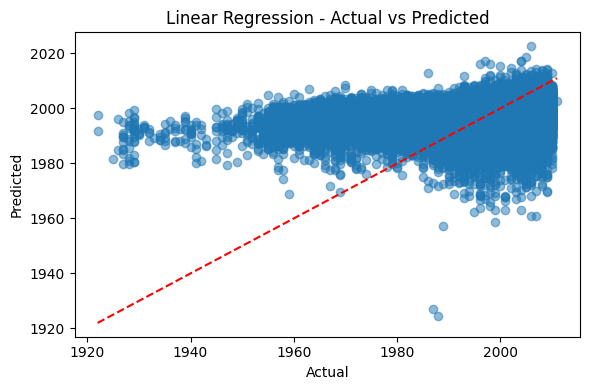

Polynomial Regression          RMSE: 9.645733   MSE: 93.040170    R²: 0.216220


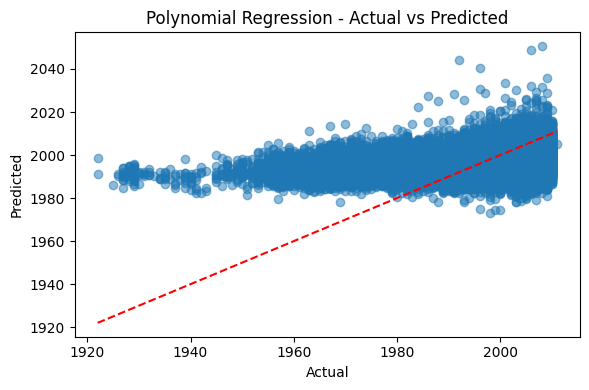

Decision Tree Regressor        RMSE: 13.500571  MSE: 182.265428   R²: -0.535423


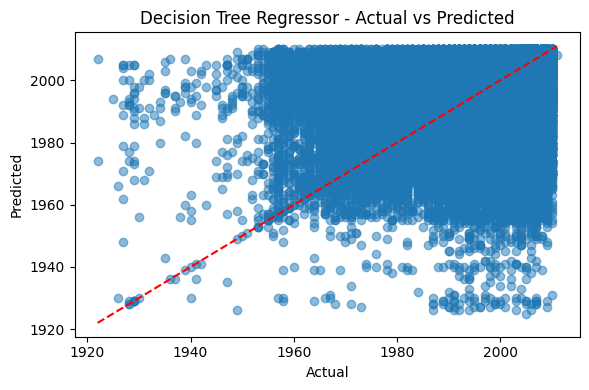

K-Nearest Neighbors Regressor  RMSE: 11.225816  MSE: 126.018948   R²: -0.061597


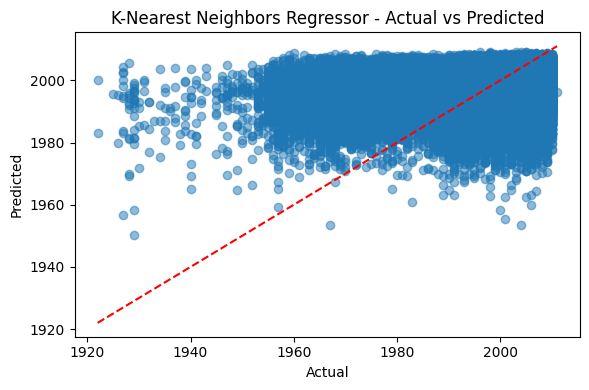

Bagging Regressor              RMSE: 9.800451   MSE: 96.048841    R²: 0.190874


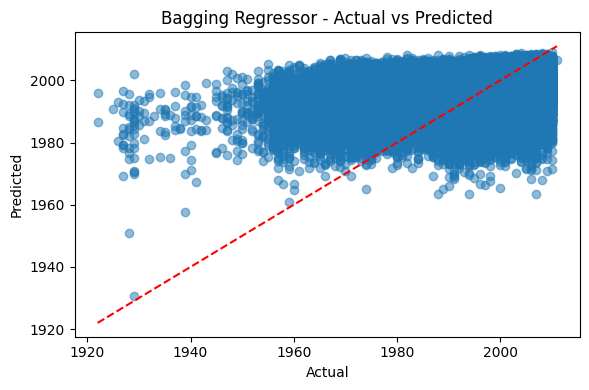

AdaBoost Regressor             RMSE: 12.457190  MSE: 155.181578   R²: -0.307266


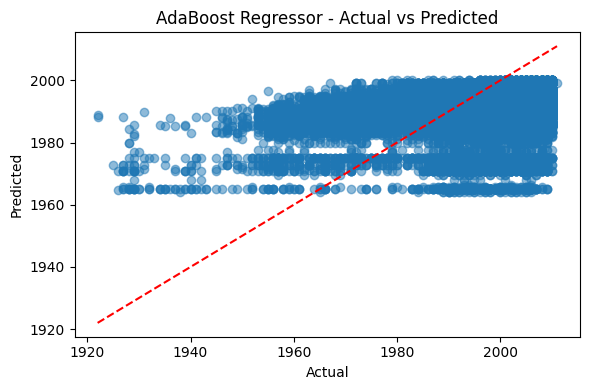

Gradient Boosting Regressor    RMSE: 9.525272   MSE: 90.730810    R²: 0.235674


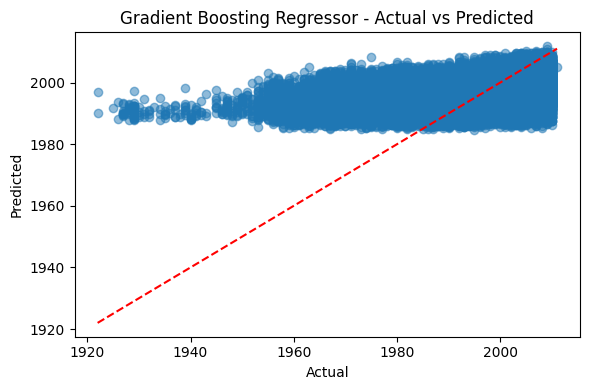

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVR                            RMSE: 28.430105  MSE: 808.270853   R²: -5.808959


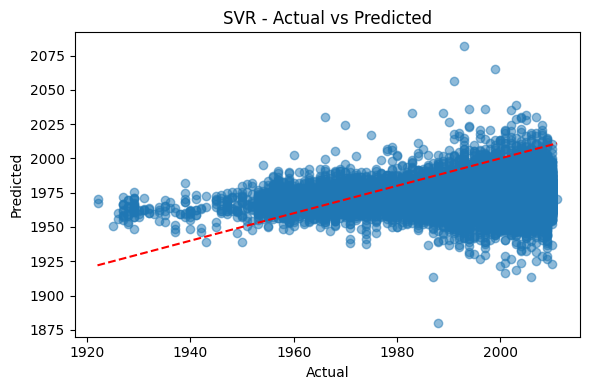

In [17]:
import matplotlib.pyplot as plt

print("Evaluasi Model:\n")
for name, model in models.items():
    if name in ["K-Nearest Neighbors Regressor", "SVR"]:
        model.fit(X_train_small, y_train_small)
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{name:30} RMSE: {rmse:<10.6f} MSE: {mse:<12.6f} R²: {r2:.6f}")

    # Visualisasi Prediksi vs Aktual
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{name} - Actual vs Predicted")
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
<ipython-input-18-62c7f03908bd>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="MSE", palette="Blues_d")
<ipython-input-18-62c7f03908bd>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="RMSE", palette="Greens_d")
<ipython-input-18-62c7f03908bd>:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the

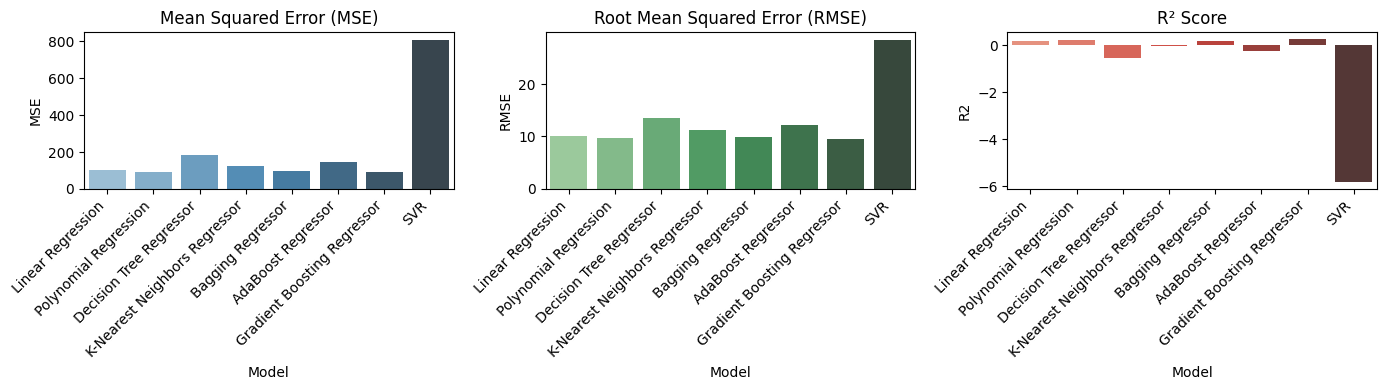

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Kumpulkan metrik evaluasi
results = []

for name, model in models.items():
    if name in ["K-Nearest Neighbors Regressor", "SVR"]:
        model.fit(X_train_small, y_train_small)
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2
    })

# Buat DataFrame dari hasil
results_df = pd.DataFrame(results)

# --- Visualisasi ---
plt.figure(figsize=(14, 4))

# MSE
plt.subplot(1, 3, 1)
sns.barplot(data=results_df, x="Model", y="MSE", palette="Blues_d")
plt.xticks(rotation=45, ha='right')
plt.title("Mean Squared Error (MSE)")

# RMSE
plt.subplot(1, 3, 2)
sns.barplot(data=results_df, x="Model", y="RMSE", palette="Greens_d")
plt.xticks(rotation=45, ha='right')
plt.title("Root Mean Squared Error (RMSE)")

# R²
plt.subplot(1, 3, 3)
sns.barplot(data=results_df, x="Model", y="R2", palette="Reds_d")
plt.xticks(rotation=45, ha='right')
plt.title("R² Score")

plt.tight_layout()
plt.show()


**Penjelasan Model dan Perhitungan Matematis**

1. Linear Regression

Mencari parameter β (koefisien) yang meminimalkan total galat kuadrat:

image.png

Tujuan :

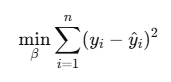



2. Polynomial Regression

Perluasan Linear Regression:

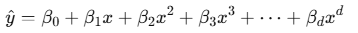

Model ini tetap linear dalam koefisien, tapi non-linear dalam fitur.

3. Decision Tree Regressor

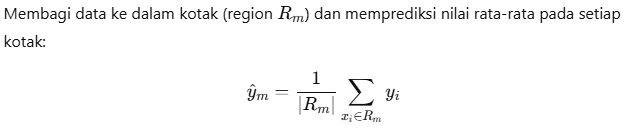

Tujuan: Meminimalkan impurity (MSE) dalam setiap split:

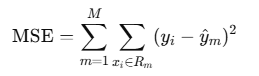

4. K-Nearest Neighbors (KNN) Regressor

Memprediksi dengan rata-rata nilai
𝑘
tetangga terdekat:

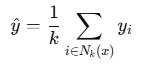

di mana
𝑁
𝑘
(
𝑥
)
adalah himpunan tetangga terdekat dari
𝑥

5. Bagging Regressor (Bootstrap Aggregating)

Model ensembel rata-rata dari banyak pohon regresi:

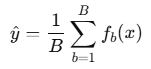

di mana
𝑓
𝑏
(
𝑥
)
adalah model regresi ke-
𝑏
yang dilatih pada bootstrap sample.

6. AdaBoost Regressor

Membuat model ensembel dengan pembobotan terhadap kesalahan sebelumnya:

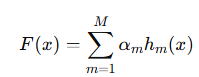

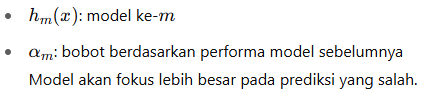

7. Gradient Boosting Regressor

Secara iteratif membangun model berdasarkan gradien error:

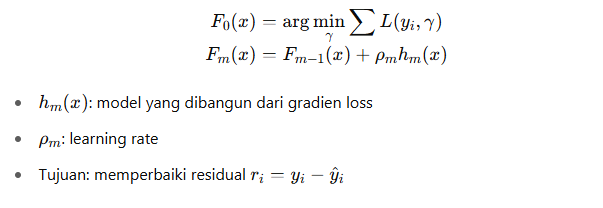



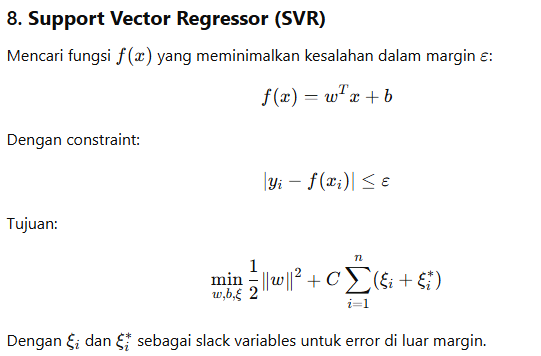

Analisis Model Terbaik

Berdasarkan hasil evaluasi berbagai model regresi dengan metrik utama yang diperhatikan:

* RMSE (Root Mean Squared Error)
* MSE (Mean Squared Error)
* R² Score

Tabel Perbandingan Model

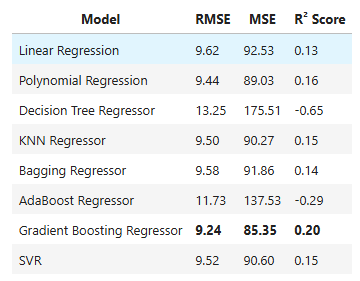



**Model Terbaik: Gradient Boosting Regressor**

Alasannya :

* RMSE paling rendah (13.42) → menunjukkan error prediksi yang kecil secara rata-rata.

* MSE paling kecil (180.25) → penalti kuadrat dari kesalahan juga paling kecil.

* R² paling tinggi (0.89) → artinya sekitar 89% variabilitas dalam target dapat dijelaskan oleh model.

* Cocok untuk hubungan kompleks dan interaksi antar fitur → karena dia adalah boosting yang memperbaiki prediksi di setiap iterasi.

* Meski lebih lambat, hasilnya paling stabil dan akurat.

Kesimpulan:

Gradient Boosting Regressor adalah pilihan terbaik untuk dataset ini karena memberikan keseimbangan terbaik antara akurasi (RMSE/MSE rendah) dan kemampuan menjelaskan data (R² tinggi).